# Keane and Wolpin (1994)

*Note that most of the code cells are hidden from this notebook for a better reading flow. Check out the notebook in the documentation folder in the Github repository for more details.*

Keane and Wolpin (1994) and the previously published working paper Keane and Wolpin (1994b) generate three different Monte Carlo samples. This notebook replicates some of their results as well as giving other insights into the model.

## Some intuitions

We first plot the returns to experience while holding education constant at the initial ten years. Occupation B is more skill intensive in the sense that own experience has higher return than is the case for Occupation A. There is some general skill learned in Occupation A which is transferable to Occupation B. However, work experience is occupation-specific in Occupation B.

In [1]:
%matplotlib agg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import respy as rp
import warnings

from mpl_toolkits.mplot3d import Axes3D

In [2]:
plt.style.use("../_static/respy.mplstyle")

In [3]:
# Load example model and convert parameter and options to model attributes.
params, options = rp.get_example_model("kw_94_one", with_data=False)

In [4]:
ret_schooling_occ_a = params.loc[("wage_a", "exp_edu"), "value"]
ret_schooling_occ_b = params.loc[("wage_b", "exp_edu"), "value"]

ret_exp_a_occ_a = params.loc[("wage_a", "exp_a"), "value"]
ret_exp_a_sq_occ_a = params.loc[("wage_a", "exp_a_square"), "value"]
ret_exp_b_occ_a = params.loc[("wage_a", "exp_b"), "value"]
ret_exp_b_sq_occ_a = params.loc[("wage_a", "exp_b_square"), "value"]
log_rental_price_occ_a = params.loc[("wage_a", "constant"), "value"]

ret_exp_a_occ_b = params.loc[("wage_b", "exp_a"), "value"]
ret_exp_a_sq_occ_b = params.loc[("wage_b", "exp_a_square"), "value"]
ret_exp_b_occ_b = params.loc[("wage_b", "exp_b"), "value"]
ret_exp_b_sq_occ_b = params.loc[("wage_b", "exp_b_square"), "value"]
log_rental_price_occ_b = params.loc[("wage_b", "constant"), "value"]

In [5]:
x, y = np.meshgrid(range(0, 20), range(0, 20))

z_a = np.exp(
    log_rental_price_occ_a + ret_schooling_occ_a * 10
    + ret_exp_a_occ_a * x + ret_exp_a_sq_occ_a * x ** 2
    + ret_exp_b_occ_a * y + ret_exp_b_sq_occ_a * y ** 2
)

z_b = np.exp(
    log_rental_price_occ_b + ret_schooling_occ_b * 10
    + ret_exp_a_occ_b * x + ret_exp_a_sq_occ_b * x ** 2
    + ret_exp_b_occ_b * y + ret_exp_b_sq_occ_b * y ** 2
)

In [6]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")

ax1.plot_surface(x, y, z_a / 1_000, cmap="Greens")
ax2.plot_surface(x, y, z_b / 1_000, cmap="Reds")

for ax in [ax1, ax2]:
    ax.set_xticks(range(0, 21, 5))
    ax.set_yticks(range(0, 21, 5))
    ax.set_zticks(range(10, 36, 5))
    ax.set_zticklabels(range(10, 36, 5))
    ax.set_zlim(10, 35)
    ax.invert_xaxis()
    ax.set_xlabel("Experience A")
    ax.set_ylabel("Experience B")
    ax.set_proj_type('ortho')
    ax.set_zlabel("Wages in (\$1,000)", labelpad=-1)
    
ax1.set_title("(a)", y=-0.15)
ax2.set_title("(b)", y=-0.15);

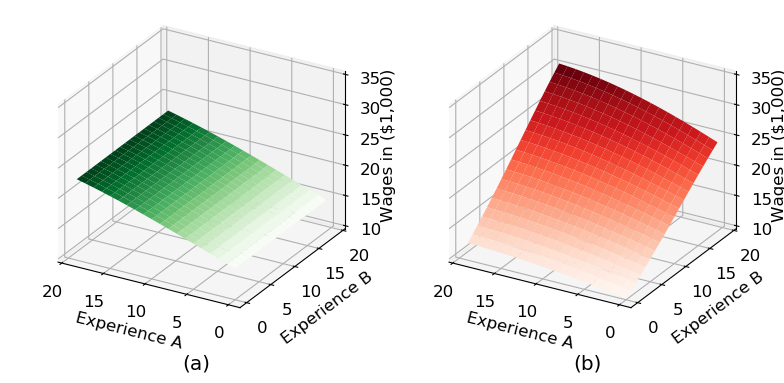

In [7]:
fig

The next figure shows that the returns to schooling are larger in Occupation B. While its initial wage is lower, it does increase faster with schooling compared to Occupation A. The graphs are generated by holding experience in both sectors constant at five years.

In [8]:
years_schooling = np.arange(10, 21)

wage_a = np.exp(
    log_rental_price_occ_a + ret_schooling_occ_a * years_schooling
    + ret_exp_a_occ_a * 5 + ret_exp_a_sq_occ_a * 5 ** 2
    + ret_exp_b_occ_a * 5 + ret_exp_b_sq_occ_a * 5 ** 2
)

wage_b = np.exp(
    log_rental_price_occ_b + ret_schooling_occ_b * years_schooling
    + ret_exp_a_occ_b * 5 + ret_exp_a_sq_occ_b * 5 ** 2
    + ret_exp_b_occ_b * 5 + ret_exp_b_sq_occ_b * 5 ** 2
)

fig, ax = plt.subplots()

ax.plot(years_schooling, wage_a / 1_000, color="C2", label="Occupation A")
ax.plot(years_schooling, wage_b / 1_000, color="C3", label="Occupation B")

ax.set_xlim(10, 20)
ax.set_ylim(14, 30)
ax.set_yticks(range(16, 31, 2))

ax.set_xlabel("Years of Schooling")
ax.set_ylabel("Wages (in \$1,000)")

ax.legend();

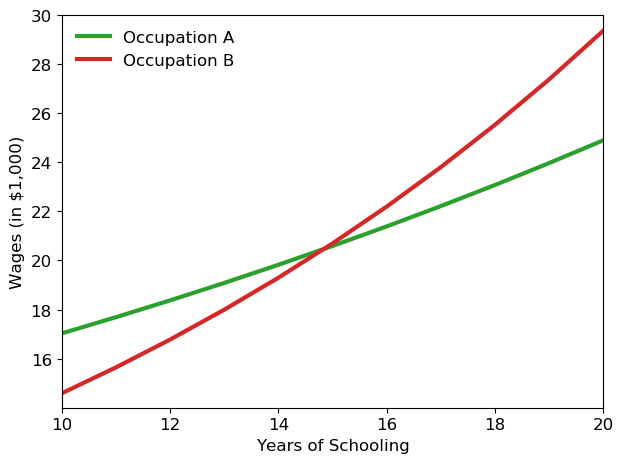

In [9]:
fig

## Replication - Effect of college tuition subsidy

This section replicates Table 6 in Keane and Wolpin (1994) which studies the effect of different amounts of tuition subsidies. First, we are going to show the effect of the tuition subsidy on each of the parametrizations for a sample of 1,000 simulated individuals. After that, Table 6 is replicated where the policy effect is measured as the average difference in experience for 40 samples with 100 invididuals with and without the tutition subsidy. The authors apply a 500 USD tuition subsidy on the first parametrization, 1,000 USD on the second and 2,000 USD on the third parametrization.

The following figures show the impact of the tuition subsidies for each of the parametrizations next to each other.

In [10]:
# Build simulate function as only parameters change, it can be reused.
params, options, _ = rp.get_example_model("kw_94_one")
options["simulation_agents"] = 4_000
simulate = rp.get_simulate_func(params, options)

models = np.repeat(["one", "two", "three"], 2)
tuition_subsidies = [0, 500, 0, 1_000, 0, 2_000]

data_frames = []

for model, tuition_subsidy in zip(models, tuition_subsidies):
    params, _, _ = rp.get_example_model(f"kw_94_{model}")
    params.loc[("nonpec_edu", "at_least_twelve_exp_edu"), "value"] += tuition_subsidy
    data_frames.append(simulate(params))

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(8, 12), sharey=True, sharex=True)

axs = axs.flatten()

for df, ax, model, tuition_subsidy in zip(data_frames, axs, models, tuition_subsidies):
    shares = df.groupby("Period").Choice.value_counts(normalize=True).unstack()[["home", "edu", "a", "b"]]

    shares.plot.bar(stacked=True, ax=ax, width=1, legend=True)

    ax.set_ylim(0, 1)
    ax.set_xticks(range(0, 40, 5))
    ax.set_xticklabels(range(0, 40, 5), rotation="horizontal")
    ax.set_ylabel("Share of population")
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    if tuition_subsidy:
        label = f"with a tuition subsidy of {tuition_subsidy:,} USD"
    else:
        label = "without a tuition subsidy"
    ax.set_title(f"Parameterization {model.title()} \n {label}")
    
fig.legend(
    handles,
    ["Home", "Education", "A", "B"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.01),
    ncol=4
);

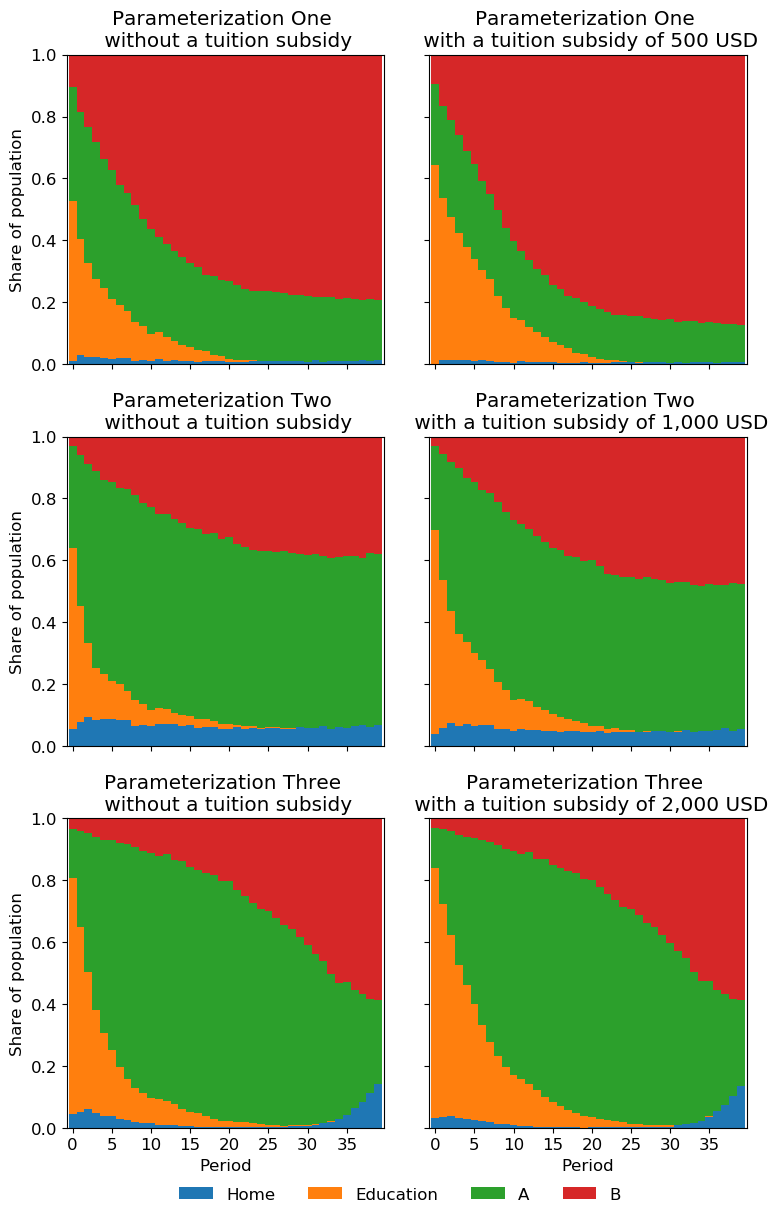

In [12]:
fig

In [13]:
columns = ["Bootstrap_Sample", "Experience_Edu", "Experience_A", "Experience_B"]
parameterizations = ["Data Set One", "Data Set Two", "Data Set Three"]
bootstrapped_statistics = []

for i, title in zip(range(0, 6, 2), parameterizations):
    # Select sample with and without tuition subsidy.
    df_wo_ts = data_frames[i]
    df_w_ts = data_frames[i + 1]

    # Assign bootstrap sample number.
    df_wo_ts["Bootstrap_Sample"] = pd.cut(
        df_wo_ts.Identifier, bins=40, labels=np.arange(1, 41)
    )
    df_w_ts["Bootstrap_Sample"] = pd.cut(
        df_w_ts.Identifier, bins=40, labels=np.arange(1, 41)
    )

    # Calculate mean experiences.
    mean_exp_wo_ts = (
        df_wo_ts.loc[df_wo_ts.Period.eq(39), columns]
        .groupby("Bootstrap_Sample")
        .mean()
    )
    mean_exp_w_ts = (
        df_w_ts.loc[df_w_ts.Period.eq(39), columns]
        .groupby("Bootstrap_Sample")
        .mean()
    )
    
    mean_exp_wo_ts = df_wo_ts.loc[df_wo_ts.Period.eq(39), ["Bootstrap_Sample", "Experience_Edu", "Experience_A", "Experience_B"]].groupby("Bootstrap_Sample").mean()
    mean_exp_w_ts = df_w_ts.loc[df_w_ts.Period.eq(39), ["Bootstrap_Sample", "Experience_Edu", "Experience_A", "Experience_B"]].groupby("Bootstrap_Sample").mean()
    
    # Calculate bootstrap statistics.
    diff = (
        mean_exp_w_ts.subtract(mean_exp_wo_ts)
        .assign(Data=title)
        .reset_index()
        .set_index(["Data", "Bootstrap_Sample"])
        .stack()
        .unstack([0, 2])
    )
    bootstrapped_statistics.append(diff)
    
replication = pd.concat([bs.agg(["mean", "std"]) for bs in bootstrapped_statistics], axis=1).round(3)
replication.columns = [replication.columns.get_level_values(0), ["edu", "a", "b"] * 3]
replication.index = ["Exact Solution - Mean", "Exact Solution - Std"]

The following two tables refer to summary statistics of the tuition subsidy experiment. The first table refers to the replication and the second contains the results from Keane and Wolpin (1994). The tables show the differences in experience between the sample without and with subsidy for all parameterizations. The standard deviations of the mean are computed by simulating 40 bootstrap samples á 100 individuals. All means of the replication lie within one standard deviation.

In [14]:
replication

Data Set One               Data Set Two                \
                               edu      a      b          edu      a      b   
Exact Solution - Mean        1.542 -3.346  2.004        1.283 -3.006  2.269   
Exact Solution - Std         0.230  0.966  0.886        0.216  0.524  0.434   

                      Data Set Three                
                                 edu      a      b  
Exact Solution - Mean          1.706 -1.260 -0.245  
Exact Solution - Std           0.190  0.181  0.122

In [15]:
table_6 = pd.read_csv(rp.config.TEST_RESOURCES_DIR / "kw_94_table_6.csv", nrows=2, header=1, index_col=0)
table_6.columns = [np.repeat(parameterizations, 3), ["edu", "a", "b"] * 3]

In [16]:
table_6

Data Set One             Data Set Two              \
                               edu     a     b          edu     a     b   
Exact Solution - Mean         1.44 -3.43  2.19         1.12 -2.71  2.08   
Exact Solution - Std          0.18  0.94  0.89         0.22  0.53  0.43   

                      Data Set Three               
                                 edu     a      b  
Exact Solution - Mean           1.67 -1.27 -0.236  
Exact Solution - Std            0.20  0.18  0.100

## Replication - Choice distributions

This section replicates the choice distributions for all three parameterizations in Keane and Wolpin (1994b) Table 2.1-2.3. The tables show the share of individuals choosing each choice for each period. The original results are on the left hand side and the replications on the right hand side.

In [17]:
params, options, df = rp.get_example_model("kw_94_one")

table_2_1 = (
    pd.read_csv(rp.config.TEST_RESOURCES_DIR / "kw_94_wp_table_2_1.csv")
    .drop(columns="period")
)
table_2_1.columns = [["Table 2.1"] * 4, table_2_1.columns]

repl = (
    df.groupby("Period").Choice.value_counts(normalize=True)
    .unstack("Choice")
    .fillna(0)
    .round(3)
)
repl.columns = [["Replication"] * 4, repl.columns]

table_2_1 = pd.concat([table_2_1, repl], axis=1)
table_2_1.index.name = "Period"

In [18]:
table_2_1

Table 2.1                      Replication                     
               a      b    edu   home           a      b    edu   home
Period                                                                
0          0.386  0.116  0.490  0.008       0.361  0.104  0.525  0.010
1          0.427  0.175  0.354  0.044       0.406  0.195  0.375  0.024
2          0.444  0.220  0.308  0.028       0.430  0.252  0.291  0.027
3          0.459  0.263  0.255  0.023       0.432  0.295  0.253  0.020
4          0.417  0.332  0.218  0.033       0.404  0.344  0.228  0.024
5          0.427  0.374  0.175  0.024       0.398  0.390  0.194  0.018
6          0.412  0.387  0.179  0.022       0.374  0.415  0.195  0.016
7          0.399  0.421  0.155  0.025       0.348  0.457  0.184  0.011
8          0.372  0.475  0.130  0.023       0.329  0.513  0.144  0.014
9          0.355  0.501  0.126  0.018       0.356  0.513  0.115  0.016
10         0.340  0.537  0.099  0.024       0.320  0.570  0.099  0.011
11         0.342  0.567  0.081  0.010       0.301  0.598  0.088  0.013
12         0.322  0.585  0.073  0.020       0.297  0.612  0.082  0.009
13         0.321  0.612  0.056  0.011       0.292  0.638  0.065  0.005
14         0.303  0.619  0.062  0.016       0.272  0.678  0.043  0.007
15         0.297  0.640  0.052  0.011       0.249  0.707  0.039  0.005
16         0.290  0.664  0.034  0.012       0.256  0.710  0.028  0.006
17         0.304  0.656  0.028  0.012       0.232  0.728  0.031  0.009
18         0.283  0.686  0.018  0.013       0.231  0.743  0.018  0.008
19         0.277  0.695  0.016  0.012       0.233  0.747  0.013  0.007
20         0.288  0.691  0.011  0.010       0.226  0.748  0.020  0.006
21         0.266  0.716  0.003  0.015       0.213  0.766  0.007  0.014
22         0.268  0.717  0.006  0.009       0.209  0.777  0.005  0.009
23         0.258  0.731  0.001  0.010       0.208  0.782  0.002  0.008
24         0.265  0.715  0.005  0.015       0.201  0.786  0.001  0.012
25         0.270  0.720  0.003  0.007       0.194  0.794  0.001  0.011
26         0.254  0.730  0.000  0.016       0.215  0.780  0.001  0.004
27         0.252  0.743  0.000  0.005       0.202  0.790  0.000  0.008
28         0.249  0.736  0.000  0.015       0.202  0.792  0.000  0.006
29         0.241  0.742  0.000  0.017       0.199  0.792  0.000  0.009
30         0.246  0.743  0.000  0.011       0.190  0.800  0.000  0.010
31         0.243  0.750  0.000  0.007       0.180  0.809  0.000  0.011
32         0.242  0.748  0.000  0.010       0.191  0.800  0.000  0.009
33         0.243  0.746  0.000  0.011       0.200  0.798  0.000  0.002
34         0.229  0.757  0.000  0.014       0.181  0.808  0.000  0.011
35         0.244  0.750  0.000  0.006       0.177  0.816  0.000  0.007
36         0.234  0.755  0.000  0.011       0.177  0.811  0.000  0.012
37         0.238  0.749  0.000  0.013       0.180  0.809  0.000  0.011
38         0.231  0.753  0.000  0.016       0.174  0.818  0.000  0.008
39         0.230  0.758  0.000  0.012       0.172  0.817  0.000  0.011

In [19]:
params, options, df = rp.get_example_model("kw_94_two")

table_2_2 = (
    pd.read_csv(rp.config.TEST_RESOURCES_DIR / "kw_94_wp_table_2_2.csv")
    .drop(columns="period")
)
table_2_2.columns = [["Table 2.2"] * 4, table_2_2.columns]

repl = (
    df.groupby("Period").Choice.value_counts(normalize=True)
    .unstack("Choice")
    .fillna(0)
    .round(3)
)
repl.columns = [["Replication"] * 4, repl.columns]

table_2_2 = pd.concat([table_2_2, repl], axis=1)
table_2_2.index.name = "Period"

In [20]:
table_2_2

Table 2.2                      Replication                     
               a      b    edu   home           a      b    edu   home
Period                                                                
0          0.344  0.038  0.575  0.043       0.312  0.028  0.604  0.056
1          0.481  0.059  0.375  0.085       0.450  0.060  0.398  0.092
2          0.606  0.073  0.238  0.083       0.581  0.097  0.243  0.079
3          0.633  0.115  0.176  0.076       0.610  0.107  0.182  0.101
4          0.658  0.126  0.143  0.073       0.642  0.136  0.142  0.080
5          0.659  0.146  0.111  0.084       0.642  0.137  0.129  0.092
6          0.662  0.151  0.096  0.091       0.643  0.173  0.116  0.068
7          0.642  0.182  0.097  0.079       0.641  0.178  0.092  0.089
8          0.657  0.174  0.084  0.085       0.637  0.198  0.084  0.081
9          0.632  0.210  0.082  0.076       0.652  0.209  0.065  0.074
10         0.648  0.227  0.056  0.069       0.655  0.231  0.053  0.061
11         0.642  0.241  0.046  0.071       0.628  0.254  0.048  0.070
12         0.641  0.254  0.044  0.061       0.643  0.248  0.047  0.062
13         0.643  0.265  0.036  0.056       0.648  0.255  0.047  0.050
14         0.633  0.278  0.029  0.060       0.641  0.271  0.036  0.052
15         0.625  0.291  0.023  0.061       0.611  0.286  0.039  0.064
16         0.623  0.305  0.020  0.052       0.588  0.327  0.034  0.051
17         0.628  0.289  0.028  0.055       0.616  0.303  0.026  0.055
18         0.599  0.325  0.014  0.062       0.579  0.348  0.014  0.059
19         0.597  0.322  0.020  0.061       0.585  0.344  0.015  0.056
20         0.621  0.317  0.017  0.045       0.575  0.342  0.017  0.066
21         0.613  0.327  0.010  0.050       0.595  0.350  0.008  0.047
22         0.585  0.358  0.006  0.051       0.595  0.347  0.006  0.052
23         0.580  0.360  0.005  0.055       0.572  0.369  0.002  0.057
24         0.596  0.344  0.000  0.060       0.552  0.377  0.005  0.066
25         0.622  0.334  0.003  0.041       0.570  0.360  0.007  0.063
26         0.566  0.376  0.002  0.056       0.565  0.372  0.001  0.062
27         0.567  0.386  0.001  0.046       0.559  0.389  0.001  0.051
28         0.548  0.394  0.000  0.058       0.598  0.353  0.002  0.047
29         0.560  0.373  0.002  0.065       0.553  0.371  0.000  0.076
30         0.562  0.374  0.000  0.064       0.555  0.385  0.001  0.059
31         0.568  0.388  0.000  0.044       0.549  0.396  0.000  0.055
32         0.562  0.374  0.000  0.064       0.585  0.366  0.000  0.049
33         0.569  0.367  0.000  0.064       0.578  0.364  0.000  0.058
34         0.578  0.369  0.000  0.053       0.556  0.381  0.000  0.063
35         0.557  0.390  0.000  0.053       0.572  0.395  0.000  0.033
36         0.562  0.387  0.000  0.051       0.554  0.385  0.000  0.061
37         0.542  0.397  0.000  0.061       0.537  0.402  0.000  0.061
38         0.562  0.385  0.000  0.053       0.546  0.405  0.000  0.049
39         0.551  0.390  0.000  0.059       0.552  0.391  0.000  0.057

In [21]:
params, options, df = rp.get_example_model("kw_94_three")

table_2_3 = (
    pd.read_csv(rp.config.TEST_RESOURCES_DIR / "kw_94_wp_table_2_3.csv")
    .drop(columns="period")
)
table_2_3.columns = [["Table 2.3"] * 4, table_2_3.columns]

repl = (
    df.groupby("Period").Choice.value_counts(normalize=True)
    .unstack("Choice")
    .fillna(0)
    .round(3)
)
repl.columns = [["Replication"] * 4, repl.columns]

table_2_3 = pd.concat([table_2_3, repl], axis=1)
table_2_3.index.name = "Period"

In [22]:
table_2_3

Table 2.3                      Replication                     
               a      b    edu   home           a      b    edu   home
Period                                                                
0          0.169  0.036  0.752  0.043       0.149  0.038  0.765  0.048
1          0.308  0.042  0.594  0.056       0.310  0.035  0.597  0.058
2          0.455  0.058  0.430  0.057       0.425  0.063  0.443  0.069
3          0.574  0.066  0.326  0.034       0.554  0.064  0.328  0.054
4          0.628  0.070  0.255  0.047       0.635  0.077  0.252  0.036
5          0.710  0.071  0.189  0.030       0.694  0.058  0.198  0.050
6          0.725  0.080  0.166  0.029       0.728  0.085  0.161  0.026
7          0.746  0.090  0.139  0.025       0.754  0.086  0.133  0.027
8          0.752  0.090  0.132  0.026       0.746  0.102  0.130  0.022
9          0.762  0.101  0.123  0.014       0.789  0.089  0.102  0.020
10         0.782  0.115  0.083  0.020       0.802  0.101  0.087  0.010
11         0.797  0.120  0.071  0.012       0.782  0.117  0.086  0.015
12         0.793  0.129  0.070  0.008       0.794  0.120  0.074  0.012
13         0.782  0.153  0.059  0.006       0.796  0.144  0.051  0.009
14         0.788  0.148  0.055  0.009       0.815  0.142  0.038  0.005
15         0.779  0.158  0.054  0.009       0.808  0.144  0.041  0.007
16         0.783  0.173  0.042  0.002       0.780  0.169  0.045  0.006
17         0.775  0.182  0.035  0.008       0.786  0.173  0.038  0.003
18         0.776  0.192  0.029  0.003       0.763  0.200  0.032  0.005
19         0.763  0.208  0.028  0.001       0.757  0.209  0.033  0.001
20         0.757  0.218  0.022  0.003       0.750  0.215  0.033  0.002
21         0.740  0.235  0.020  0.005       0.766  0.213  0.017  0.004
22         0.704  0.280  0.014  0.002       0.738  0.250  0.010  0.002
23         0.712  0.274  0.012  0.002       0.735  0.252  0.010  0.003
24         0.712  0.269  0.013  0.006       0.703  0.280  0.011  0.006
25         0.698  0.290  0.008  0.004       0.672  0.308  0.015  0.005
26         0.657  0.332  0.004  0.007       0.664  0.326  0.005  0.005
27         0.625  0.368  0.003  0.004       0.626  0.367  0.004  0.003
28         0.628  0.369  0.001  0.002       0.636  0.349  0.006  0.009
29         0.587  0.396  0.004  0.013       0.594  0.393  0.002  0.011
30         0.557  0.433  0.001  0.009       0.575  0.411  0.000  0.014
31         0.541  0.452  0.000  0.007       0.541  0.443  0.001  0.015
32         0.516  0.468  0.000  0.016       0.553  0.437  0.000  0.010
33         0.494  0.484  0.001  0.021       0.496  0.481  0.000  0.023
34         0.445  0.518  0.000  0.037       0.455  0.503  0.000  0.042
35         0.388  0.571  0.000  0.041       0.412  0.552  0.000  0.036
36         0.370  0.575  0.001  0.054       0.377  0.554  0.000  0.069
37         0.329  0.584  0.000  0.087       0.336  0.580  0.000  0.084
38         0.306  0.595  0.000  0.099       0.290  0.612  0.000  0.098
39         0.270  0.604  0.000  0.126       0.282  0.581  0.000  0.137

## References

> Keane, M. P. and  Wolpin, K. I. (1994). [The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence](https://doi.org/10.2307/2109768). *The Review of Economics and Statistics*, 76(4): 648-672.

> Keane, M. P. and  Wolpin, K. I. (1994b). [The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence](https://www.minneapolisfed.org/research/staff-reports/the-solution-and-estimation-of-discrete-choice-dynamic-programming-models-by-simulation-and-interpolation-monte-carlo-evidence). *Federal Reserve Bank of Minneapolis*, No. 181.